## **Taller 2 - Fundamentos de Analítica de Datos**
### **Daniel Martínez Villegas & Luis Felipe Montenegro**

**Importación de Librerías**

In [1]:
import os
import os.path as osp
import shutil
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import torchvision.ops as ops
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import typing as ty
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import cv2
from skimage import io, transform
from numpy.typing import NDArray


## **Sección I: CNN Personalizado**

En esta sección nos enfocamos en la preparación de los datos para la estructuración de un modelo de red neuronal convolucional (CNN). El objetivo es preparar adecuadamente los conjuntos de entrenamiento y validación, asegurándonos de que las imágenes estén organizadas por clases en directorios separados.



In [11]:
data_dir = 'data'  
train_dir = os.path.join(data_dir, 'train_cnn')
validation_dir = os.path.join(data_dir, 'test_cnn')


os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [12]:
train_info = pd.read_csv('train.csv')  


X = train_info[['filename']]
y = train_info['class_id']

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Combinar características y etiquetas en DataFrames
train_data = pd.concat([X_train, y_train], axis=1)
validation_data = pd.concat([X_val, y_val], axis=1)

In [ ]:
def create_train_test_img_folder(train_df, test_df, image_source_dir='images'):
    splits = {'train_cnn': train_df, 'test_cnn': test_df}
    for split, df in splits.items():
        for i, row in df.iterrows():
            source_file = os.path.join(image_source_dir, row['filename'])
            
            # Asignar la subcarpeta basada en la clase
            class_name = 'pinguino' if row['class_id'] == 1 else 'tortuga'
            destination_folder = os.path.join(data_dir, split, class_name)
            
            # Crear la carpeta de destino si no existe
            os.makedirs(destination_folder, exist_ok=True)
            
            # Copiar el archivo a la carpeta correspondiente
            shutil.copy(source_file, destination_folder)
    
    print("Imágenes copiadas a las carpetas 'train_cnn' y 'test_cnn'.")


create_train_test_img_folder(train_data, validation_data)


Imágenes copiadas a las carpetas 'train_cnn' y 'test_cnn'.


Ahora bien, en este punto definimos una función para crear un modelo de red convolucional, entre las capas estructuradas se tiene:

- **Capas de convolución y normalización:** Estas capas extraen características relevantes de las imágenes, aplicando funciones de activación ReLU y normalización por lotes para mejorar la estabilidad del entrenamiento.

- **Capas de MaxPooling:** Se buscó reducir la dimensionalidad espacial, manteniendo las características más importantes.

- **Capa de aplanamiento:**  Se convirtieron las salidas de las capas convolucionales en un vector plano para conectarla a la parte densa del modelo.

- **Capas densas y de regularización:** A través de la capa densa con Dropout se busca evitar el overfitting y la última capa con activación softmax se utiliza para la clasificación en dos categorías.

Finalmente, se realizó la compilación del modelo usando Adam como optimizador y categorical_crossentropy como función de pérdida.

In [14]:
def create_optimized_cnn(input_shape):
    inputs = Input(shape=input_shape)

    # Primera capa de convolución
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Segunda capa de convolución
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Tercera capa de convolución
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Cuarta capa de convolución
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Quinta capa de convolución
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Capa de aplanamiento
    x = Flatten()(x)

    # Capa totalmente conectada con regularización
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Cabeza de clasificación
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Crear el modelo optimizado
input_shape = (128, 128, 3)
model_optimized = create_optimized_cnn(input_shape)

# Compilar el modelo optimizado
model_optimized.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo optimizado
model_optimized.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,768,386 (22.00 MB)

 Trainable params: 5,766,402 (22.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

En esta sección se configuran los generadores de datos para realiar la preparación de los conjuntos de entrenamiento y validación. Se aplican transformaciones como **rotación**, **desplazamientos**, **cambios de escala**, **horizontal flip** a las imagenes del conjunto de entrenamiento. También, se configura un generador más simple para la validación en la que se normalizaron los valores de los pixeles dividiendolos por 255. 



In [15]:
train_dir = 'data/train_cnn'
validation_dir = 'data/test_cnn'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Crear un generador de datos para el conjunto de validación
validation_datagen = ImageDataGenerator(rescale=1./255)

# Crear el dataset de entrenamiento
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Crear el dataset de validación
validation_dataset = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


for images, labels in train_dataset:
    print(images.shape, labels.shape)
    break

for images, labels in validation_dataset:
    print(images.shape, labels.shape)
    break


Found 379 images belonging to 2 classes.
Found 95 images belonging to 2 classes.
(32, 128, 128, 3) (32, 2)
(32, 128, 128, 3) (32, 2)


En esta última parte de la sección, se lleva a cabo el entrenamiento del modelo, la evaluación del mismo en el conjunto de validación y finalmente se guarda el modelo para realizar pruebas posteriores de clasificación a imagenes que no se encuentran en el dominio de los conjuntos que se están trabajando. Se decide realizar el entrenamiento con un total de 100 épocas. 

In [16]:
# Entrenar el modelo optimizado
history_optimized = model_optimized.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset
)


c:\Users\monte\.conda\envs\images\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5671 - loss: 8.5666 - val_accuracy: 0.4947 - val_loss: 0.6792
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 768ms/step - accuracy: 0.7133 - loss: 1.6389 - val_accuracy: 0.5053 - val_loss: 0.8787
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 782ms/step - accuracy: 0.7299 - loss: 1.6928 - val_accuracy: 0.6421 - val_loss: 0.6464
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 848ms/step - accuracy: 0.7648 - loss: 0.8940 - val_accuracy: 0.5895 - val_loss: 0.7283
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 867ms/step - accuracy: 0.7371 - loss: 0.9503 - val_accuracy: 0.5053 - val_loss: 1.4731
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 789ms/step - accuracy: 0.7574 - loss: 0.7081 - val_accuracy: 0.5053 - val_loss: 1.0935
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 857ms/step - accuracy: 0.7843 - loss: 0.5844 - val_accuracy: 0.5053 - val_loss: 1.8833
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 853ms/step - accuracy: 0.7898 - loss: 0.4532 - val_a

El modelo propuesto alcanzó una exactitud de 0.905, lo que significa que acertó el 90.5% de las predicciones en el conjunto de validación. A pesar de que se encontró un buen resultado en términos de accuracy, la perdida identificada (0.1967) indica que aun hay margen de mejora.

In [17]:
loss_optimized, accuracy_optimized = model_optimized.evaluate(validation_dataset)
print(f'Loss: {loss_optimized}, Accuracy: {accuracy_optimized}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.9331 - loss: 0.1357
Loss: 0.19671988487243652, Accuracy: 0.9052631855010986


In [18]:
model_optimized.save('modelo_CNN_personalizado.h5')

A continuación, se decidió realizar algunas pruebas utilizando el modelo construido, la cual consistió en descargar imagenes de internet y revisar qué tan bueno es el modelo para clasificarlas correctamente.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


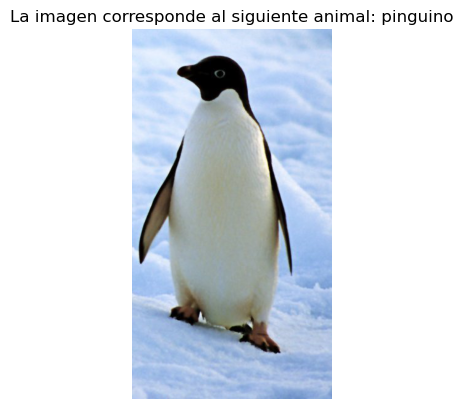

In [19]:


model = load_model('modelo_CNN_personalizado.h5')

# Función para preprocesar una imagen nueva
def preprocess_new_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizar la imagen
    return img_array

# Clasificación de la nueva imagen
def classify_and_show_image(img_path):
    img_array = preprocess_new_image(img_path)
    predictions = model.predict(img_array)
    class_names = ['pinguino', 'tortuga']
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'La imagen corresponde al siguiente animal: {predicted_class}')
    plt.show()


img_path = 'New_Images/Pinguino_1.jpg'  
classify_and_show_image(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


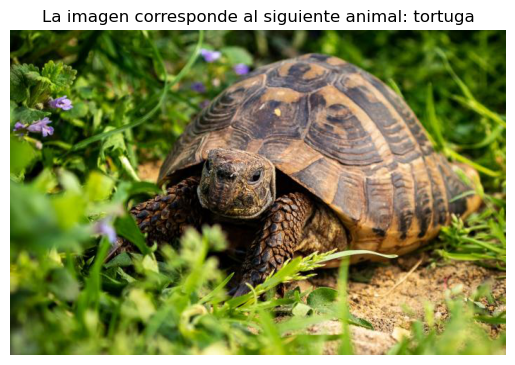

In [20]:
# Función para preprocesar una imagen nueva
def preprocess_new_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizar la imagen
    return img_array

# Clasificación de la nueva imagen
def classify_and_show_image(img_path):
    img_array = preprocess_new_image(img_path)
    predictions = model.predict(img_array)
    class_names = ['pinguino', 'tortuga']
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'La imagen corresponde al siguiente animal: {predicted_class}')
    plt.show()


img_path = 'New_Images/Tortuga_1.jpg'  
classify_and_show_image(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


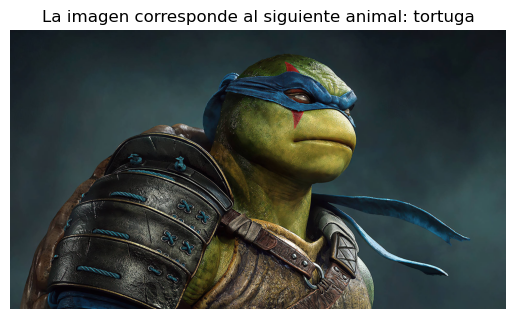

In [21]:
# Función para preprocesar una imagen nueva
def preprocess_new_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizar la imagen
    return img_array

# Clasificación de la nueva imagen
def classify_and_show_image(img_path):
    img_array = preprocess_new_image(img_path)
    predictions = model.predict(img_array)
    class_names = ['pinguino', 'tortuga']
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'La imagen corresponde al siguiente animal: {predicted_class}')
    plt.show()


img_path = 'New_Images/Tortuga_Ninja.jpg'  
classify_and_show_image(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


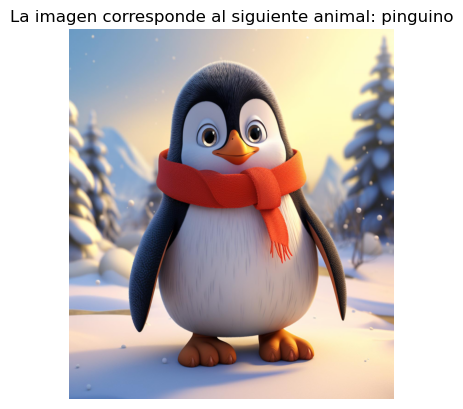

In [22]:
# Función para preprocesar una imagen nueva
def preprocess_new_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizar la imagen
    return img_array

# Clasificación de la nueva imagen
def classify_and_show_image(img_path):
    img_array = preprocess_new_image(img_path)
    predictions = model.predict(img_array)
    class_names = ['pinguino', 'tortuga']
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'La imagen corresponde al siguiente animal: {predicted_class}')
    plt.show()


img_path = 'New_Images/Pinguino_Animado.jpg'  
classify_and_show_image(img_path)


## **Sección II. Cuadros Delimitadores, Clasificación, Data Augmentation y Transfer Learning**

In [2]:
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [3]:
train_info = pd.read_csv('train.csv')
test_info = pd.read_csv('test.csv')

X = train_info[['filename', 'xmin', 'ymin', 'xmax', 'ymax']]
y = train_info['class_id']

data = pd.concat([X, y], axis=1)	

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
validation_data = pd.concat([X_val, y_val], axis=1)

In [4]:
# Using the train-test fot the training and validation data folders
def create_train_validation_img_folder(train_df, val_df):
    splits = {'train': train_df, 'validation': val_df}
    for split, df in splits.items():
        for i, row in df.iterrows():
            source_file = f'images/{row["filename"]}'
            destination_folder = f'data/{split}'
            os.makedirs(destination_folder, exist_ok=True)
            destination_file = os.path.join(destination_folder)
            shutil.copy(source_file, destination_file)

# Using the test data for the test folder
def create_test_img_folder(test_df):
	for i, row in test_df.iterrows():
		source_file = f'images/{row["filename"]}'
		destination_folder = 'data/test'
		os.makedirs(destination_folder, exist_ok=True)
		destination_file = os.path.join(destination_folder)
		shutil.copy(source_file, destination_file)

# Creating the folders
create_train_validation_img_folder(train_data, validation_data)
create_test_img_folder(test_info)

En esta sección se llevó a cabo la creación de un Dataset personalizado para manejar imágenes con sus respectivas etiquetas y coordenadas de cajas delimitadoras. El conjunto de datos se carga desde un archivo, y se aplican transformaciones como aumentos de imagen (para entrenamiento) y redimensionamiento (para validación). Seguido a esto, se utilizan DataLoaders para organizar los datos en lotes de 16 imágenes.Por otro lado, se definieron dos funciones de pérdida: una para la clasificación (usando CrossEntropyLoss) y otra para la regresión de las cajas delimitadoras (con SmoothL1Loss). 

In [5]:
class BoundingBoxDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = os.path.join(self.root_dir, row['filename'])
        image = plt.imread(img_name)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Extract bounding box coordinates
        bbox = torch.tensor([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
        
        label = torch.tensor(row['class_id'] - 1)  # Subtract 1 to make labels 0-based

        return image, label, bbox


In [6]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((255, 255), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Load train and test data
train_dataset = BoundingBoxDataset(train_data, root_dir=train_dir, transform=train_transforms)
validation_dataset = BoundingBoxDataset(validation_data, root_dir=validation_dir, transform=validation_transforms)

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Loss functions
classification_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.SmoothL1Loss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## VGG16

En este punto del desarrollo del trabajo se construyó un modelo basado en VGG16 para realizar dos tareas al mismo tiempo: clasificación y regresión de cajas delimitadoras. Usamos la parte inicial del modelo VGG16, que se encarga de extraer las características de las imágenes. Después, pasamos esas características por unas capas completamente conectadas que son compartidas entre las dos tareas con el objetivo de buscar más eficiencia.Aquí se resalta que en lugar de tener dos redes separadas, el modelo tiene dos salidas: una para predecir las clases de la imagen y otra para predecir las coordenadas de las cajas que rodean los objetos. 

In [8]:
class MultiTaskVGG16(nn.Module):
    def __init__(self, base_model):
        super(MultiTaskVGG16, self).__init__()
        
        # Base feature extractor
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.flatten = nn.Flatten()
        
        # Shared fully connected layers
        self.shared_fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Classification head
        self.classifier = nn.Linear(4096, 2)
        
        # Bounding box regression head
        self.regressor = nn.Linear(4096, 4) 

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        
        class_output = self.classifier(x)
        bbox_output = self.regressor(x)
        
        return class_output, bbox_output




## InceptionV3

Aquí se llevó a cabo la definición un modelo basado en InceptionV3 para realizar las tareas de clasificación y regresión de cajas delimitadoras de manera conjunta. Se tomaron las capas de convolución del modelo original hasta antes de las últimas capas de pooling, con el objetivo de aprovechar las  características que InceptionV3 puede extraer de las imágenes. Después de las convoluciones, pasamos los datos por una capa de promediado adaptativo y luego se aplanaron para hacerlos compatibles con las capas totalmente conectadas.

El modelo tiene dos salidas: 

- **Clasificación:** predice si la imagen pertenece a una de dos clases
  
- **Regresión:** predice las coordenadas de la caja delimitadora

In [9]:
class MultiTaskInceptionV3(nn.Module):
    def __init__(self):
        super(MultiTaskInceptionV3, self).__init__()
        
        # Load the Inception_v3 model
        base_model = models.inception_v3(pretrained=True, aux_logits=True)
        
        # Use the model's Conv2d layers up to the last pooling layer as the feature extractor
        self.features = nn.Sequential(
            base_model.Conv2d_1a_3x3,
            base_model.Conv2d_2a_3x3,
            base_model.Conv2d_2b_3x3,
            base_model.maxpool1,
            base_model.Conv2d_3b_1x1,
            base_model.Conv2d_4a_3x3,
            base_model.maxpool2,
            base_model.Mixed_5b,
            base_model.Mixed_5c,
            base_model.Mixed_5d,
            base_model.Mixed_6a,
            base_model.Mixed_6b,
            base_model.Mixed_6c,
            base_model.Mixed_6d,
            base_model.Mixed_6e,
            base_model.Mixed_7a,
            base_model.Mixed_7b,
            base_model.Mixed_7c,
        )
        
        # Average pooling and flatten
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        # Fully connected shared layers
        self.shared_fc = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Classification head
        self.classifier = nn.Linear(4096, 2)
        
        # Bounding box regression head
        self.regressor = nn.Linear(4096, 4)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        
        class_output = self.classifier(x)
        bbox_output = self.regressor(x)
        
        return class_output, bbox_output

## **Custom train function using any given model**

La funció está diseñada para ser personalizada y flexible, permitiendo que se use con cualquier modelo que siga una estructura específica de entrada y salida. En este cvaso, el diseño permitió que la función pueda recibir modelos que no solo realizan 

En este caso, la función es capaz de manejar modelos que no solo realicen tareas de clasificación, sino también de regresión (como la predicción de coordenadas de una caja delimitadora).

In [10]:
def train(model, train_loader, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels, bboxes in tqdm(train_loader):
        images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
        
        optimizer.zero_grad()
        class_outputs, bbox_outputs = model(images)
        
        # Compute losses
        class_loss = classification_criterion(class_outputs, labels)
        bbox_loss = regression_criterion(bbox_outputs, bboxes.float())
        loss = class_loss + bbox_loss  # Combine losses
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

## IoU Metric

In [11]:
def calculate_iou(pred_boxes, true_boxes):
    return ops.box_iou(pred_boxes, true_boxes).diag().mean().item()

## Evaluate

En esta sección se implementó una función para evaluar el rendimiento del modelo en el conjunto de prueba. Durante la evaluación, se calculó la pérdida total combinando las pérdidas de clasificación y regresión y se acumularon para obtener la pérdida promedio al final. Adicionalmente,  se configuraron predicciones de clase y se calcularon las métricas de precisión y el IoU  para evaluar la calidad de las cajas delimitadoras predichas. 

In [12]:
def evaluate(model, test_loader, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    iou_scores = []
    
    with torch.no_grad():
        for images, labels, bboxes in tqdm(test_loader):
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            
            class_outputs, bbox_outputs = model(images)
            
            # Compute losses
            class_loss = classification_criterion(class_outputs, labels)
            bbox_loss = regression_criterion(bbox_outputs, bboxes.float())
            loss = class_loss + bbox_loss
            running_loss += loss.item() * images.size(0)
            
            # Store predictions and labels for accuracy calculation
            preds = class_outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Calculate IoU and append to list
            iou = calculate_iou(bbox_outputs, bboxes)
            iou_scores.append(iou)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)  # Classification accuracy
    average_iou = sum(iou_scores) / len(iou_scores)  # Average IoU across the dataset
    epoch_loss = running_loss / len(test_loader.dataset)
    
    return epoch_loss, accuracy, average_iou



## VGG16 trainning

In [13]:
base_model = models.vgg16(pretrained=True)

# Freeze the base model layers
for param in base_model.parameters():
    param.requires_grad = False

# Initialize model
model = MultiTaskVGG16(base_model).to(device)
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

c:\Users\monte\.conda\envs\images\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\monte\.conda\envs\images\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
def train_model(model, train_loader, validation_loader, optimizer, device, num_epochs=10):
    best_accuracy = 0.0
    best_IoU = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        train_loss = train(model, train_loader, optimizer, device)
        val_loss, val_accuracy, test_iou = evaluate(model, validation_loader, device)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Test Average IoU: {test_iou:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_IoU = test_iou
            torch.save(model.state_dict(), "best_model_full.pth")
            print("Saved Best Model!")

In [15]:
train_model(model, train_loader, validation_loader, optimizer, device, num_epochs=1)

Epoch 1/1


100%|██████████| 6/6 [00:24<00:00,  4.14s/it]


Train Loss: 174.4045
Validation Loss: 116.5913
Validation Accuracy: 0.9579
Test Average IoU: 0.0330
Saved Best Model!


## InceptioV3 trainning

In [16]:
model = MultiTaskInceptionV3().to(device)

# Freeze the base model layers
for param in model.features.parameters():
    param.requires_grad = False

# Optimizer (only fine-tuning the final layers)
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)


c:\Users\monte\.conda\envs\images\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\monte\.conda\envs\images\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
train_model(model, train_loader, validation_loader, optimizer, device, num_epochs=1)

Epoch 1/1


100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


Train Loss: 222.9238
Validation Loss: 185.1539
Validation Accuracy: 0.4947
Test Average IoU: 0.0000
Saved Best Model!


# Predict

En esta sección se implementaron varias funciones relacionadas con la predicción y el manejo de un conjunto de datos de prueba sin etiquetas. Los pasos fueron los siguientes:

I. se creó un dataset personalizado para la validación/test sin etiquetas, que carga imágenes a partir de un archivo CSV que contiene los nombres de los archivos de imagen, y aplica transformaciones como redimensionar, normalizar y convertir las imágenes a tensores. 

II. Se configuró un DataLoader para cargar este dataset y realizar inferencias de manera eficiente. 

III. Se definió una función predict_and_save_unlabeled que realiza predicciones sobre el conjunto de datos, obteniendo tanto la clase predicha como las coordenadas de las cajas delimitadoras para cada imagen, y guarda estas predicciones en un archivo CSV, asegurándose de no duplicar las predicciones para los mismos archivos. 

IV. Finalmente, se cargó el modelo previamente entrenado y se ejecutó la función de predicción para guardar los resultados en un archivo CSV.

In [18]:
# Custom dataset for validation/test set without labels
class TestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = self.data.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, filename  # Only return image and filename


In [19]:
# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Paths
csv_file = 'test.csv'
img_dir = 'images'

# Create the dataset and loader
test_dataset = TestDataset(csv_file, img_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [20]:
# Inference and saving to CSV for unlabeled validation/test set
def predict_and_save_unlabeled(model, loader, device, output_file="test_predictions.csv"):
    model.eval()
    predictions = []
    seen_filenames = set()  # Track unique filenames to avoid duplicates
    
    with torch.no_grad():
        for images, filenames in loader:  # Accepts images and filenames only
            images = images.to(device)
            class_outputs, bbox_outputs = model(images)
            
            # Get predicted class (1-based indexing)
            class_preds = class_outputs.argmax(dim=1).cpu().numpy() + 1  
            # Get bounding box predictions
            bbox_preds = bbox_outputs.cpu().numpy()
            
            # Save predictions for each file
            for filename, class_id, bbox_pred in zip(filenames, class_preds, bbox_preds):
                # Only add unique filenames
                if filename not in seen_filenames:
                    predictions.append([filename, class_id, *bbox_pred])
                    seen_filenames.add(filename)  # Mark this filename as seen
    
    # Save predictions to CSV
    submission_df = pd.DataFrame(predictions, columns=[
        "filename", "pred_class_id", "pred_xmin", "pred_ymin", "pred_xmax", "pred_ymax"
    ])
    submission_df.to_csv(output_file, index=False)
    
    print(f"Saved predictions to {output_file}")

# Run the prediction and save function for validation/test data
# predict_and_save_unlabeled(model, test_loader, device, output_file="test_predictions_perfect.csv")


base_model = models.vgg16(pretrained=True)
model = MultiTaskVGG16(base_model).to(device)
model.load_state_dict(torch.load("best_model_full.pth"))
# Run the prediction and save function
predict_and_save_unlabeled(model, test_loader, device, output_file="hola.csv")



c:\Users\monte\.conda\envs\images\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\monte\.conda\envs\images\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Error(s) in loading state_dict for MultiTaskVGG16:
	Missing key(s) in state_dict: "features.0.weight", "features.0.bias", "features.2.weight", "features.2.bias", "features.5.weight", "features.5.bias", "features.7.weight", "features.7.bias", "features.10.weight", "features.10.bias", "features.12.weight", "features.12.bias", "features.14.weight", "features.14.bias", "features.17.weight", "features.17.bias", "features.19.weight", "features.19.bias", "features.21.weight", "features.21.bias", "features.24.weight", "features.24.bias", "features.26.weight", "features.26.bias", "features.28.weight", "features.28.bias". 
	Unexpected key(s) in state_dict: "features.0.conv.weight", "features.0.bn.weight", "features.0.bn.bias", "features.0.bn.running_mean", "features.0.bn.running_var", "features.0.bn.num_batches_tracked", "features.1.conv.weight", "features.1.bn.weight", "features.1.bn.bias", "features.1.bn.running_mean", "features.1.bn.running_var", "features.1.bn.num_batches_tracked", "features.2.conv.weight", "features.2.bn.weight", "features.2.bn.bias", "features.2.bn.running_mean", "features.2.bn.running_var", "features.2.bn.num_batches_tracked", "features.4.conv.weight", "features.4.bn.weight", "features.4.bn.bias", "features.4.bn.running_mean", "features.4.bn.running_var", "features.4.bn.num_batches_tracked", "features.5.conv.weight", "features.5.bn.weight", "features.5.bn.bias", "features.5.bn.running_mean", "features.5.bn.running_var", "features.5.bn.num_batches_tracked", "features.7.branch1x1.conv.weight", "features.7.branch1x1.bn.weight", "features.7.branch1x1.bn.bias", "features.7.branch1x1.bn.running_mean", "features.7.branch1x1.bn.running_var", "features.7.branch1x1.bn.num_batches_tracked", "features.7.branch5x5_1.conv.weight", "features.7.branch5x5_1.bn.weight", "features.7.branch5x5_1.bn.bias", "features.7.branch5x5_1.bn.running_mean", "features.7.branch5x5_1.bn.running_var", "features.7.branch5x5_1.bn.num_batches_tracked", "features.7.branch5x5_2.conv.weight", "features.7.branch5x5_2.bn.weight", "features.7.branch5x5_2.bn.bias", "features.7.branch5x5_2.bn.running_mean", "features.7.branch5x5_2.bn.running_var", "features.7.branch5x5_2.bn.num_batches_tracked", "features.7.branch3x3dbl_1.conv.weight", "features.7.branch3x3dbl_1.bn.weight", "features.7.branch3x3dbl_1.bn.bias", "features.7.branch3x3dbl_1.bn.running_mean", "features.7.branch3x3dbl_1.bn.running_var", "features.7.branch3x3dbl_1.bn.num_batches_tracked", "features.7.branch3x3dbl_2.conv.weight", "features.7.branch3x3dbl_2.bn.weight", "features.7.branch3x3dbl_2.bn.bias", "features.7.branch3x3dbl_2.bn.running_mean", "features.7.branch3x3dbl_2.bn.running_var", "features.7.branch3x3dbl_2.bn.num_batches_tracked", "features.7.branch3x3dbl_3.conv.weight", "features.7.branch3x3dbl_3.bn.weight", "features.7.branch3x3dbl_3.bn.bias", "features.7.branch3x3dbl_3.bn.running_mean", "features.7.branch3x3dbl_3.bn.running_var", "features.7.branch3x3dbl_3.bn.num_batches_tracked", "features.7.branch_pool.conv.weight", "features.7.branch_pool.bn.weight", "features.7.branch_pool.bn.bias", "features.7.branch_pool.bn.running_mean", "features.7.branch_pool.bn.running_var", "features.7.branch_pool.bn.num_batches_tracked", "features.8.branch1x1.conv.weight", "features.8.branch1x1.bn.weight", "features.8.branch1x1.bn.bias", "features.8.branch1x1.bn.running_mean", "features.8.branch1x1.bn.running_var", "features.8.branch1x1.bn.num_batches_tracked", "features.8.branch5x5_1.conv.weight", "features.8.branch5x5_1.bn.weight", "features.8.branch5x5_1.bn.bias", "features.8.branch5x5_1.bn.running_mean", "features.8.branch5x5_1.bn.running_var", "features.8.branch5x5_1.bn.num_batches_tracked", "features.8.branch5x5_2.conv.weight", "features.8.branch5x5_2.bn.weight", "features.8.branch5x5_2.bn.bias", "features.8.branch5x5_2.bn.running_mean", "features.8.branch5x5_2.bn.running_var", "features.8.branch5x5_2.bn.num_batches_tracked", "features.8.branch3x3dbl_1.conv.weight", "features.8.branch3x3dbl_1.bn.weight", "features.8.branch3x3dbl_1.bn.bias", "features.8.branch3x3dbl_1.bn.running_mean", "features.8.branch3x3dbl_1.bn.running_var", "features.8.branch3x3dbl_1.bn.num_batches_tracked", "features.8.branch3x3dbl_2.conv.weight", "features.8.branch3x3dbl_2.bn.weight", "features.8.branch3x3dbl_2.bn.bias", "features.8.branch3x3dbl_2.bn.running_mean", "features.8.branch3x3dbl_2.bn.running_var", "features.8.branch3x3dbl_2.bn.num_batches_tracked", "features.8.branch3x3dbl_3.conv.weight", "features.8.branch3x3dbl_3.bn.weight", "features.8.branch3x3dbl_3.bn.bias", "features.8.branch3x3dbl_3.bn.running_mean", "features.8.branch3x3dbl_3.bn.running_var", "features.8.branch3x3dbl_3.bn.num_batches_tracked", "features.8.branch_pool.conv.weight", "features.8.branch_pool.bn.weight", "features.8.branch_pool.bn.bias", "features.8.branch_pool.bn.running_mean", "features.8.branch_pool.bn.running_var", "features.8.branch_pool.bn.num_batches_tracked", "features.9.branch1x1.conv.weight", "features.9.branch1x1.bn.weight", "features.9.branch1x1.bn.bias", "features.9.branch1x1.bn.running_mean", "features.9.branch1x1.bn.running_var", "features.9.branch1x1.bn.num_batches_tracked", "features.9.branch5x5_1.conv.weight", "features.9.branch5x5_1.bn.weight", "features.9.branch5x5_1.bn.bias", "features.9.branch5x5_1.bn.running_mean", "features.9.branch5x5_1.bn.running_var", "features.9.branch5x5_1.bn.num_batches_tracked", "features.9.branch5x5_2.conv.weight", "features.9.branch5x5_2.bn.weight", "features.9.branch5x5_2.bn.bias", "features.9.branch5x5_2.bn.running_mean", "features.9.branch5x5_2.bn.running_var", "features.9.branch5x5_2.bn.num_batches_tracked", "features.9.branch3x3dbl_1.conv.weight", "features.9.branch3x3dbl_1.bn.weight", "features.9.branch3x3dbl_1.bn.bias", "features.9.branch3x3dbl_1.bn.running_mean", "features.9.branch3x3dbl_1.bn.running_var", "features.9.branch3x3dbl_1.bn.num_batches_tracked", "features.9.branch3x3dbl_2.conv.weight", "features.9.branch3x3dbl_2.bn.weight", "features.9.branch3x3dbl_2.bn.bias", "features.9.branch3x3dbl_2.bn.running_mean", "features.9.branch3x3dbl_2.bn.running_var", "features.9.branch3x3dbl_2.bn.num_batches_tracked", "features.9.branch3x3dbl_3.conv.weight", "features.9.branch3x3dbl_3.bn.weight", "features.9.branch3x3dbl_3.bn.bias", "features.9.branch3x3dbl_3.bn.running_mean", "features.9.branch3x3dbl_3.bn.running_var", "features.9.branch3x3dbl_3.bn.num_batches_tracked", "features.9.branch_pool.conv.weight", "features.9.branch_pool.bn.weight", "features.9.branch_pool.bn.bias", "features.9.branch_pool.bn.running_mean", "features.9.branch_pool.bn.running_var", "features.9.branch_pool.bn.num_batches_tracked", "features.10.branch3x3.conv.weight", "features.10.branch3x3.bn.weight", "features.10.branch3x3.bn.bias", "features.10.branch3x3.bn.running_mean", "features.10.branch3x3.bn.running_var", "features.10.branch3x3.bn.num_batches_tracked", "features.10.branch3x3dbl_1.conv.weight", "features.10.branch3x3dbl_1.bn.weight", "features.10.branch3x3dbl_1.bn.bias", "features.10.branch3x3dbl_1.bn.running_mean", "features.10.branch3x3dbl_1.bn.running_var", "features.10.branch3x3dbl_1.bn.num_batches_tracked", "features.10.branch3x3dbl_2.conv.weight", "features.10.branch3x3dbl_2.bn.weight", "features.10.branch3x3dbl_2.bn.bias", "features.10.branch3x3dbl_2.bn.running_mean", "features.10.branch3x3dbl_2.bn.running_var", "features.10.branch3x3dbl_2.bn.num_batches_tracked", "features.10.branch3x3dbl_3.conv.weight", "features.10.branch3x3dbl_3.bn.weight", "features.10.branch3x3dbl_3.bn.bias", "features.10.branch3x3dbl_3.bn.running_mean", "features.10.branch3x3dbl_3.bn.running_var", "features.10.branch3x3dbl_3.bn.num_batches_tracked", "features.11.branch1x1.conv.weight", "features.11.branch1x1.bn.weight", "features.11.branch1x1.bn.bias", "features.11.branch1x1.bn.running_mean", "features.11.branch1x1.bn.running_var", "features.11.branch1x1.bn.num_batches_tracked", "features.11.branch7x7_1.conv.weight", "features.11.branch7x7_1.bn.weight", "features.11.branch7x7_1.bn.bias", "features.11.branch7x7_1.bn.running_mean", "features.11.branch7x7_1.bn.running_var", "features.11.branch7x7_1.bn.num_batches_tracked", "features.11.branch7x7_2.conv.weight", "features.11.branch7x7_2.bn.weight", "features.11.branch7x7_2.bn.bias", "features.11.branch7x7_2.bn.running_mean", "features.11.branch7x7_2.bn.running_var", "features.11.branch7x7_2.bn.num_batches_tracked", "features.11.branch7x7_3.conv.weight", "features.11.branch7x7_3.bn.weight", "features.11.branch7x7_3.bn.bias", "features.11.branch7x7_3.bn.running_mean", "features.11.branch7x7_3.bn.running_var", "features.11.branch7x7_3.bn.num_batches_tracked", "features.11.branch7x7dbl_1.conv.weight", "features.11.branch7x7dbl_1.bn.weight", "features.11.branch7x7dbl_1.bn.bias", "features.11.branch7x7dbl_1.bn.running_mean", "features.11.branch7x7dbl_1.bn.running_var", "features.11.branch7x7dbl_1.bn.num_batches_tracked", "features.11.branch7x7dbl_2.conv.weight", "features.11.branch7x7dbl_2.bn.weight", "features.11.branch7x7dbl_2.bn.bias", "features.11.branch7x7dbl_2.bn.running_mean", "features.11.branch7x7dbl_2.bn.running_var", "features.11.branch7x7dbl_2.bn.num_batches_tracked", "features.11.branch7x7dbl_3.conv.weight", "features.11.branch7x7dbl_3.bn.weight", "features.11.branch7x7dbl_3.bn.bias", "features.11.branch7x7dbl_3.bn.running_mean", "features.11.branch7x7dbl_3.bn.running_var", "features.11.branch7x7dbl_3.bn.num_batches_tracked", "features.11.branch7x7dbl_4.conv.weight", "features.11.branch7x7dbl_4.bn.weight", "features.11.branch7x7dbl_4.bn.bias", "features.11.branch7x7dbl_4.bn.running_mean", "features.11.branch7x7dbl_4.bn.running_var", "features.11.branch7x7dbl_4.bn.num_batches_tracked", "features.11.branch7x7dbl_5.conv.weight", "features.11.branch7x7dbl_5.bn.weight", "features.11.branch7x7dbl_5.bn.bias", "features.11.branch7x7dbl_5.bn.running_mean", "features.11.branch7x7dbl_5.bn.running_var", "features.11.branch7x7dbl_5.bn.num_batches_tracked", "features.11.branch_pool.conv.weight", "features.11.branch_pool.bn.weight", "features.11.branch_pool.bn.bias", "features.11.branch_pool.bn.running_mean", "features.11.branch_pool.bn.running_var", "features.11.branch_pool.bn.num_batches_tracked", "features.12.branch1x1.conv.weight", "features.12.branch1x1.bn.weight", "features.12.branch1x1.bn.bias", "features.12.branch1x1.bn.running_mean", "features.12.branch1x1.bn.running_var", "features.12.branch1x1.bn.num_batches_tracked", "features.12.branch7x7_1.conv.weight", "features.12.branch7x7_1.bn.weight", "features.12.branch7x7_1.bn.bias", "features.12.branch7x7_1.bn.running_mean", "features.12.branch7x7_1.bn.running_var", "features.12.branch7x7_1.bn.num_batches_tracked", "features.12.branch7x7_2.conv.weight", "features.12.branch7x7_2.bn.weight", "features.12.branch7x7_2.bn.bias", "features.12.branch7x7_2.bn.running_mean", "features.12.branch7x7_2.bn.running_var", "features.12.branch7x7_2.bn.num_batches_tracked", "features.12.branch7x7_3.conv.weight", "features.12.branch7x7_3.bn.weight", "features.12.branch7x7_3.bn.bias", "features.12.branch7x7_3.bn.running_mean", "features.12.branch7x7_3.bn.running_var", "features.12.branch7x7_3.bn.num_batches_tracked", "features.12.branch7x7dbl_1.conv.weight", "features.12.branch7x7dbl_1.bn.weight", "features.12.branch7x7dbl_1.bn.bias", "features.12.branch7x7dbl_1.bn.running_mean", "features.12.branch7x7dbl_1.bn.running_var", "features.12.branch7x7dbl_1.bn.num_batches_tracked", "features.12.branch7x7dbl_2.conv.weight", "features.12.branch7x7dbl_2.bn.weight", "features.12.branch7x7dbl_2.bn.bias", "features.12.branch7x7dbl_2.bn.running_mean", "features.12.branch7x7dbl_2.bn.running_var", "features.12.branch7x7dbl_2.bn.num_batches_tracked", "features.12.branch7x7dbl_3.conv.weight", "features.12.branch7x7dbl_3.bn.weight", "features.12.branch7x7dbl_3.bn.bias", "features.12.branch7x7dbl_3.bn.running_mean", "features.12.branch7x7dbl_3.bn.running_var", "features.12.branch7x7dbl_3.bn.num_batches_tracked", "features.12.branch7x7dbl_4.conv.weight", "features.12.branch7x7dbl_4.bn.weight", "features.12.branch7x7dbl_4.bn.bias", "features.12.branch7x7dbl_4.bn.running_mean", "features.12.branch7x7dbl_4.bn.running_var", "features.12.branch7x7dbl_4.bn.num_batches_tracked", "features.12.branch7x7dbl_5.conv.weight", "features.12.branch7x7dbl_5.bn.weight", "features.12.branch7x7dbl_5.bn.bias", "features.12.branch7x7dbl_5.bn.running_mean", "features.12.branch7x7dbl_5.bn.running_var", "features.12.branch7x7dbl_5.bn.num_batches_tracked", "features.12.branch_pool.conv.weight", "features.12.branch_pool.bn.weight", "features.12.branch_pool.bn.bias", "features.12.branch_pool.bn.running_mean", "features.12.branch_pool.bn.running_var", "features.12.branch_pool.bn.num_batches_tracked", "features.13.branch1x1.conv.weight", "features.13.branch1x1.bn.weight", "features.13.branch1x1.bn.bias", "features.13.branch1x1.bn.running_mean", "features.13.branch1x1.bn.running_var", "features.13.branch1x1.bn.num_batches_tracked", "features.13.branch7x7_1.conv.weight", "features.13.branch7x7_1.bn.weight", "features.13.branch7x7_1.bn.bias", "features.13.branch7x7_1.bn.running_mean", "features.13.branch7x7_1.bn.running_var", "features.13.branch7x7_1.bn.num_batches_tracked", "features.13.branch7x7_2.conv.weight", "features.13.branch7x7_2.bn.weight", "features.13.branch7x7_2.bn.bias", "features.13.branch7x7_2.bn.running_mean", "features.13.branch7x7_2.bn.running_var", "features.13.branch7x7_2.bn.num_batches_tracked", "features.13.branch7x7_3.conv.weight", "features.13.branch7x7_3.bn.weight", "features.13.branch7x7_3.bn.bias", "features.13.branch7x7_3.bn.running_mean", "features.13.branch7x7_3.bn.running_var", "features.13.branch7x7_3.bn.num_batches_tracked", "features.13.branch7x7dbl_1.conv.weight", "features.13.branch7x7dbl_1.bn.weight", "features.13.branch7x7dbl_1.bn.bias", "features.13.branch7x7dbl_1.bn.running_mean", "features.13.branch7x7dbl_1.bn.running_var", "features.13.branch7x7dbl_1.bn.num_batches_tracked", "features.13.branch7x7dbl_2.conv.weight", "features.13.branch7x7dbl_2.bn.weight", "features.13.branch7x7dbl_2.bn.bias", "features.13.branch7x7dbl_2.bn.running_mean", "features.13.branch7x7dbl_2.bn.running_var", "features.13.branch7x7dbl_2.bn.num_batches_tracked", "features.13.branch7x7dbl_3.conv.weight", "features.13.branch7x7dbl_3.bn.weight", "features.13.branch7x7dbl_3.bn.bias", "features.13.branch7x7dbl_3.bn.running_mean", "features.13.branch7x7dbl_3.bn.running_var", "features.13.branch7x7dbl_3.bn.num_batches_tracked", "features.13.branch7x7dbl_4.conv.weight", "features.13.branch7x7dbl_4.bn.weight", "features.13.branch7x7dbl_4.bn.bias", "features.13.branch7x7dbl_4.bn.running_mean", "features.13.branch7x7dbl_4.bn.running_var", "features.13.branch7x7dbl_4.bn.num_batches_tracked", "features.13.branch7x7dbl_5.conv.weight", "features.13.branch7x7dbl_5.bn.weight", "features.13.branch7x7dbl_5.bn.bias", "features.13.branch7x7dbl_5.bn.running_mean", "features.13.branch7x7dbl_5.bn.running_var", "features.13.branch7x7dbl_5.bn.num_batches_tracked", "features.13.branch_pool.conv.weight", "features.13.branch_pool.bn.weight", "features.13.branch_pool.bn.bias", "features.13.branch_pool.bn.running_mean", "features.13.branch_pool.bn.running_var", "features.13.branch_pool.bn.num_batches_tracked", "features.14.branch1x1.conv.weight", "features.14.branch1x1.bn.weight", "features.14.branch1x1.bn.bias", "features.14.branch1x1.bn.running_mean", "features.14.branch1x1.bn.running_var", "features.14.branch1x1.bn.num_batches_tracked", "features.14.branch7x7_1.conv.weight", "features.14.branch7x7_1.bn.weight", "features.14.branch7x7_1.bn.bias", "features.14.branch7x7_1.bn.running_mean", "features.14.branch7x7_1.bn.running_var", "features.14.branch7x7_1.bn.num_batches_tracked", "features.14.branch7x7_2.conv.weight", "features.14.branch7x7_2.bn.weight", "features.14.branch7x7_2.bn.bias", "features.14.branch7x7_2.bn.running_mean", "features.14.branch7x7_2.bn.running_var", "features.14.branch7x7_2.bn.num_batches_tracked", "features.14.branch7x7_3.conv.weight", "features.14.branch7x7_3.bn.weight", "features.14.branch7x7_3.bn.bias", "features.14.branch7x7_3.bn.running_mean", "features.14.branch7x7_3.bn.running_var", "features.14.branch7x7_3.bn.num_batches_tracked", "features.14.branch7x7dbl_1.conv.weight", "features.14.branch7x7dbl_1.bn.weight", "features.14.branch7x7dbl_1.bn.bias", "features.14.branch7x7dbl_1.bn.running_mean", "features.14.branch7x7dbl_1.bn.running_var", "features.14.branch7x7dbl_1.bn.num_batches_tracked", "features.14.branch7x7dbl_2.conv.weight", "features.14.branch7x7dbl_2.bn.weight", "features.14.branch7x7dbl_2.bn.bias", "features.14.branch7x7dbl_2.bn.running_mean", "features.14.branch7x7dbl_2.bn.running_var", "features.14.branch7x7dbl_2.bn.num_batches_tracked", "features.14.branch7x7dbl_3.conv.weight", "features.14.branch7x7dbl_3.bn.weight", "features.14.branch7x7dbl_3.bn.bias", "features.14.branch7x7dbl_3.bn.running_mean", "features.14.branch7x7dbl_3.bn.running_var", "features.14.branch7x7dbl_3.bn.num_batches_tracked", "features.14.branch7x7dbl_4.conv.weight", "features.14.branch7x7dbl_4.bn.weight", "features.14.branch7x7dbl_4.bn.bias", "features.14.branch7x7dbl_4.bn.running_mean", "features.14.branch7x7dbl_4.bn.running_var", "features.14.branch7x7dbl_4.bn.num_batches_tracked", "features.14.branch7x7dbl_5.conv.weight", "features.14.branch7x7dbl_5.bn.weight", "features.14.branch7x7dbl_5.bn.bias", "features.14.branch7x7dbl_5.bn.running_mean", "features.14.branch7x7dbl_5.bn.running_var", "features.14.branch7x7dbl_5.bn.num_batches_tracked", "features.14.branch_pool.conv.weight", "features.14.branch_pool.bn.weight", "features.14.branch_pool.bn.bias", "features.14.branch_pool.bn.running_mean", "features.14.branch_pool.bn.running_var", "features.14.branch_pool.bn.num_batches_tracked", "features.15.branch3x3_1.conv.weight", "features.15.branch3x3_1.bn.weight", "features.15.branch3x3_1.bn.bias", "features.15.branch3x3_1.bn.running_mean", "features.15.branch3x3_1.bn.running_var", "features.15.branch3x3_1.bn.num_batches_tracked", "features.15.branch3x3_2.conv.weight", "features.15.branch3x3_2.bn.weight", "features.15.branch3x3_2.bn.bias", "features.15.branch3x3_2.bn.running_mean", "features.15.branch3x3_2.bn.running_var", "features.15.branch3x3_2.bn.num_batches_tracked", "features.15.branch7x7x3_1.conv.weight", "features.15.branch7x7x3_1.bn.weight", "features.15.branch7x7x3_1.bn.bias", "features.15.branch7x7x3_1.bn.running_mean", "features.15.branch7x7x3_1.bn.running_var", "features.15.branch7x7x3_1.bn.num_batches_tracked", "features.15.branch7x7x3_2.conv.weight", "features.15.branch7x7x3_2.bn.weight", "features.15.branch7x7x3_2.bn.bias", "features.15.branch7x7x3_2.bn.running_mean", "features.15.branch7x7x3_2.bn.running_var", "features.15.branch7x7x3_2.bn.num_batches_tracked", "features.15.branch7x7x3_3.conv.weight", "features.15.branch7x7x3_3.bn.weight", "features.15.branch7x7x3_3.bn.bias", "features.15.branch7x7x3_3.bn.running_mean", "features.15.branch7x7x3_3.bn.running_var", "features.15.branch7x7x3_3.bn.num_batches_tracked", "features.15.branch7x7x3_4.conv.weight", "features.15.branch7x7x3_4.bn.weight", "features.15.branch7x7x3_4.bn.bias", "features.15.branch7x7x3_4.bn.running_mean", "features.15.branch7x7x3_4.bn.running_var", "features.15.branch7x7x3_4.bn.num_batches_tracked", "features.16.branch1x1.conv.weight", "features.16.branch1x1.bn.weight", "features.16.branch1x1.bn.bias", "features.16.branch1x1.bn.running_mean", "features.16.branch1x1.bn.running_var", "features.16.branch1x1.bn.num_batches_tracked", "features.16.branch3x3_1.conv.weight", "features.16.branch3x3_1.bn.weight", "features.16.branch3x3_1.bn.bias", "features.16.branch3x3_1.bn.running_mean", "features.16.branch3x3_1.bn.running_var", "features.16.branch3x3_1.bn.num_batches_tracked", "features.16.branch3x3_2a.conv.weight", "features.16.branch3x3_2a.bn.weight", "features.16.branch3x3_2a.bn.bias", "features.16.branch3x3_2a.bn.running_mean", "features.16.branch3x3_2a.bn.running_var", "features.16.branch3x3_2a.bn.num_batches_tracked", "features.16.branch3x3_2b.conv.weight", "features.16.branch3x3_2b.bn.weight", "features.16.branch3x3_2b.bn.bias", "features.16.branch3x3_2b.bn.running_mean", "features.16.branch3x3_2b.bn.running_var", "features.16.branch3x3_2b.bn.num_batches_tracked", "features.16.branch3x3dbl_1.conv.weight", "features.16.branch3x3dbl_1.bn.weight", "features.16.branch3x3dbl_1.bn.bias", "features.16.branch3x3dbl_1.bn.running_mean", "features.16.branch3x3dbl_1.bn.running_var", "features.16.branch3x3dbl_1.bn.num_batches_tracked", "features.16.branch3x3dbl_2.conv.weight", "features.16.branch3x3dbl_2.bn.weight", "features.16.branch3x3dbl_2.bn.bias", "features.16.branch3x3dbl_2.bn.running_mean", "features.16.branch3x3dbl_2.bn.running_var", "features.16.branch3x3dbl_2.bn.num_batches_tracked", "features.16.branch3x3dbl_3a.conv.weight", "features.16.branch3x3dbl_3a.bn.weight", "features.16.branch3x3dbl_3a.bn.bias", "features.16.branch3x3dbl_3a.bn.running_mean", "features.16.branch3x3dbl_3a.bn.running_var", "features.16.branch3x3dbl_3a.bn.num_batches_tracked", "features.16.branch3x3dbl_3b.conv.weight", "features.16.branch3x3dbl_3b.bn.weight", "features.16.branch3x3dbl_3b.bn.bias", "features.16.branch3x3dbl_3b.bn.running_mean", "features.16.branch3x3dbl_3b.bn.running_var", "features.16.branch3x3dbl_3b.bn.num_batches_tracked", "features.16.branch_pool.conv.weight", "features.16.branch_pool.bn.weight", "features.16.branch_pool.bn.bias", "features.16.branch_pool.bn.running_mean", "features.16.branch_pool.bn.running_var", "features.16.branch_pool.bn.num_batches_tracked", "features.17.branch1x1.conv.weight", "features.17.branch1x1.bn.weight", "features.17.branch1x1.bn.bias", "features.17.branch1x1.bn.running_mean", "features.17.branch1x1.bn.running_var", "features.17.branch1x1.bn.num_batches_tracked", "features.17.branch3x3_1.conv.weight", "features.17.branch3x3_1.bn.weight", "features.17.branch3x3_1.bn.bias", "features.17.branch3x3_1.bn.running_mean", "features.17.branch3x3_1.bn.running_var", "features.17.branch3x3_1.bn.num_batches_tracked", "features.17.branch3x3_2a.conv.weight", "features.17.branch3x3_2a.bn.weight", "features.17.branch3x3_2a.bn.bias", "features.17.branch3x3_2a.bn.running_mean", "features.17.branch3x3_2a.bn.running_var", "features.17.branch3x3_2a.bn.num_batches_tracked", "features.17.branch3x3_2b.conv.weight", "features.17.branch3x3_2b.bn.weight", "features.17.branch3x3_2b.bn.bias", "features.17.branch3x3_2b.bn.running_mean", "features.17.branch3x3_2b.bn.running_var", "features.17.branch3x3_2b.bn.num_batches_tracked", "features.17.branch3x3dbl_1.conv.weight", "features.17.branch3x3dbl_1.bn.weight", "features.17.branch3x3dbl_1.bn.bias", "features.17.branch3x3dbl_1.bn.running_mean", "features.17.branch3x3dbl_1.bn.running_var", "features.17.branch3x3dbl_1.bn.num_batches_tracked", "features.17.branch3x3dbl_2.conv.weight", "features.17.branch3x3dbl_2.bn.weight", "features.17.branch3x3dbl_2.bn.bias", "features.17.branch3x3dbl_2.bn.running_mean", "features.17.branch3x3dbl_2.bn.running_var", "features.17.branch3x3dbl_2.bn.num_batches_tracked", "features.17.branch3x3dbl_3a.conv.weight", "features.17.branch3x3dbl_3a.bn.weight", "features.17.branch3x3dbl_3a.bn.bias", "features.17.branch3x3dbl_3a.bn.running_mean", "features.17.branch3x3dbl_3a.bn.running_var", "features.17.branch3x3dbl_3a.bn.num_batches_tracked", "features.17.branch3x3dbl_3b.conv.weight", "features.17.branch3x3dbl_3b.bn.weight", "features.17.branch3x3dbl_3b.bn.bias", "features.17.branch3x3dbl_3b.bn.running_mean", "features.17.branch3x3dbl_3b.bn.running_var", "features.17.branch3x3dbl_3b.bn.num_batches_tracked", "features.17.branch_pool.conv.weight", "features.17.branch_pool.bn.weight", "features.17.branch_pool.bn.bias", "features.17.branch_pool.bn.running_mean", "features.17.branch_pool.bn.running_var", "features.17.branch_pool.bn.num_batches_tracked". 
	size mismatch for shared_fc.0.weight: copying a param with shape torch.Size([4096, 2048]) from checkpoint, the shape in current model is torch.Size([4096, 25088]).

# Show results

Finalmente, para esta sección se procesaron las predicciones del modelo de detección de objetos, ajustando las clases y las coordenadas de las cajas delimitadoras para su correcta interpretación. Luego, se implementaron funciones para visualizar las predicciones sobre las imágenes, destacando las clases detectadas y sus correspondientes cajas delimitadoras. Esto permitió generar una representación visual clara de los resultados, validando así el desempeño del modelo en un conjunto de datos desconocido o más bien que no cuente con las etiquetas.

In [21]:
DATA_DIR = ''
hw_real=640
h, w, c = 255, 255, 3 # The heigh, width and number of channels of each image

In [22]:
df_predicted = pd.read_csv("hola.csv")
df_predicted['pred_class_id'] = np.where(df_predicted['pred_class_id']==2,1,0)

obj2id = {
    "penguin": 0, 
    "turtle": 1
}

id2obj = {
    0: "penguin",
    1: "turtle"
}

df_predicted['pred_xmax'] = df_predicted['pred_xmin'] + df_predicted['pred_xmax']
df_predicted['pred_ymax'] = df_predicted['pred_ymin'] + df_predicted['pred_ymax']


df_predicted["class"] = df_predicted["pred_class_id"].map(id2obj)


In [23]:
df_predicted[["pred_xmin", "pred_ymin", "pred_xmax", "pred_ymax"]] /= hw_real

In [24]:
transform_func_inp_signature = ty.Dict[str, NDArray[np.float_]]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],
    transform_func_inp_signature
]

class ImageDataset(Dataset):
    """
    Location image dataset
    """
    def __init__(
        self, 
        df: pd.DataFrame, 
        root_dir: str, 
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None,
        output_size: ty.Optional[tuple] = None  # Añadir parámetro para tamaño de salida
    ) -> None:
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        self.output_size = output_size  # Almacenar el tamaño de salida
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx: int) -> transform_func_signature: 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Read image
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        image = io.imread(img_name)
        
        #print(f"Dimensiones originales de la imagen: {image.shape}")  # Agregar para depuración

        if image.ndim == 2:  # Si la imagen está en escala de grises
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convertir a RGB
        elif image.shape[2] == 4:  # Si la imagen es RGBA
            image = image[:, :, :3] 
            
        # Redimensionar la imagen si se especifica un tamaño de salida
        if self.output_size:
            image = cv2.resize(image, self.output_size)
        
        sample = {'image': image}
        
        if self.labeled:
            # print(self.df.pred_class_id)
            img_class = self.df.pred_class_id.iloc[idx]
            img_bbox = self.df.iloc[idx, 2:6]
            img_bbox = np.array([img_bbox]).astype('float')
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [25]:
def draw_bbox(img, bbox, color):
    xmin, ymin, xmax, ymax = bbox
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
    return img

def normalize_bbox(bbox, factor : int = 255):
    return list(map(lambda x: int(x * factor), bbox))

def draw_bboxes(imgs, bboxes, colors):
    for i, (img, bbox, color) in enumerate(zip(imgs, bboxes, colors)):
        imgs[i] = draw_bbox(img, bbox, color)
    return imgs

def draw_classes(imgs, classes, colors, origin, offset: int = 5, prefix: str =''):
    for i, (img, class_id, color) in enumerate(zip(imgs, classes, colors)): 
        if type(c)==list:
            name_class_=id2obj[classes[i]]
        else:
            name_class_=id2obj[classes[i][0]]
        imgs[i] = cv2.putText(
            img, f'{prefix}{name_class_}', #class_id.squeeze()
            origin, cv2.FONT_HERSHEY_SIMPLEX, 
            0.4, color, 1, cv2.LINE_AA
        )
    return imgs

def draw_predictions(imgs, classes, bboxes, colors, origin):
    assert all(len(x) > 0 for x in [imgs, classes, bboxes, colors])
    if len(colors) == 1:
        colors = [colors[0] for _ in imgs]
    imgs = draw_bboxes(imgs, bboxes, colors)
    imgs = draw_classes(imgs, classes, colors, origin)
    return imgs

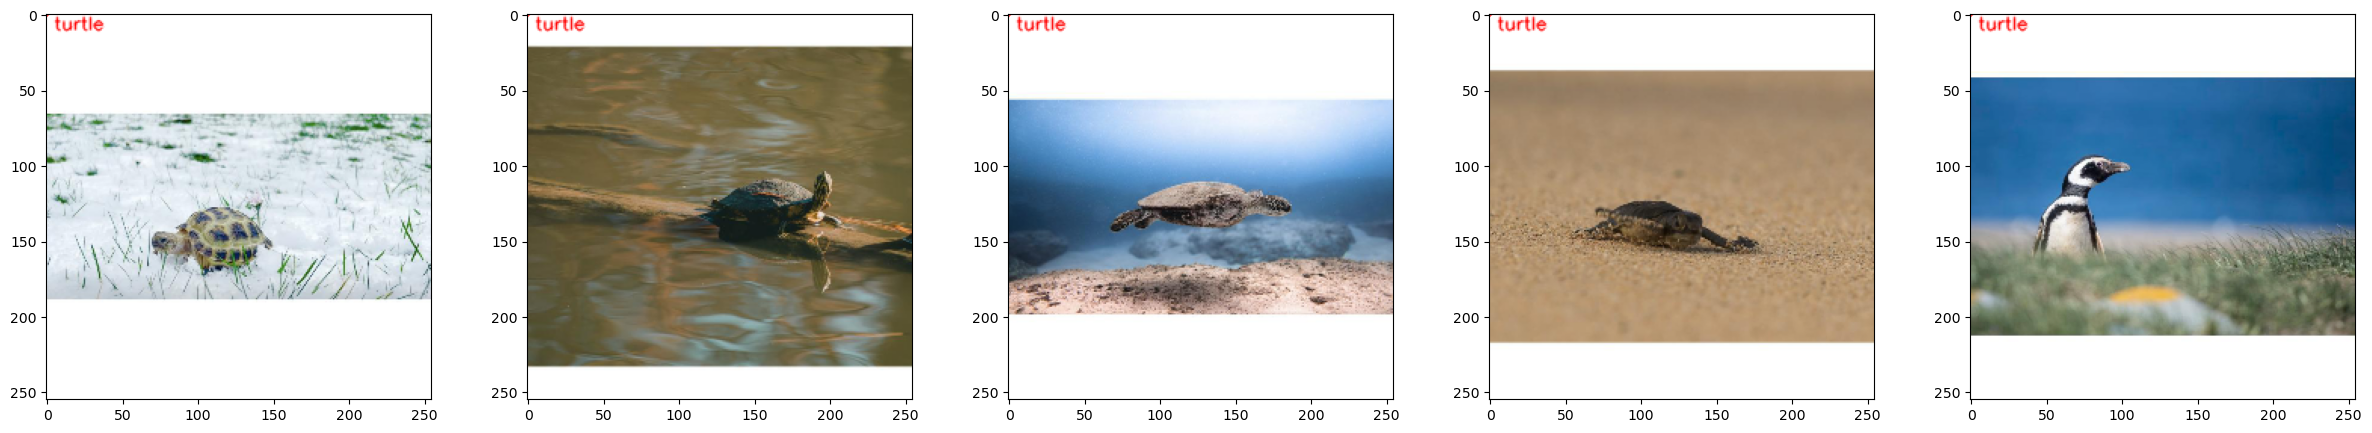

In [26]:
import random as rand
train_root_dir = osp.join(DATA_DIR, "images")

train_ds = ImageDataset(df_predicted, root_dir=train_root_dir,output_size=(255,255))

num_imgs = 5
start_idx = rand.randint(0, len(train_ds) - num_imgs)



samples = [train_ds[i] for i in range(start_idx, start_idx + num_imgs)]


imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze()) for s in samples]


classes = [s['class_id'] for s in samples]
imgs = draw_predictions(imgs, classes, bboxes, [(255, 0, 0)], (5, 10))#(150, 10)
classes

fig = plt.figure(figsize=(30, num_imgs))

for i, img in enumerate(imgs):
    fig.add_subplot(1, num_imgs, i+1)
    plt.imshow(img)

plt.show()